# Purchase Prediction using a LSTM RNN

# Background 

This notebook was published as part of an <a href="https://aws.amazon.com/blogs/machine-learning/amazon-pinpoint-campaigns-driven-by-machine-learning-on-amazon-sagemaker/"> AWS ML blog </a>. It is the second notebook of two published as part of the blog. The <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/notebooks/Retail%2BData%2BDiscovery%2Band%2BProcessing%2Bv1.0.ipynb"> first notebook </a> presents the bulk of the data discovery and processing steps described in the blog. This second notebook takes the dataset generated by the first notebook, and demonstrates the training and model serving steps involved in a ML process to deploy a custom Tensorflow model in SageMaker. 

Read the blog for context around the use case.

The dataset referenced by this notebook originates from the public UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/online+retail

<b> Source: </b>

Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.

<b> Data Set Information: </b>

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

<b> Attribute Information: </b>

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. Description: Product (item) name. Nominal. Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. UnitPrice: Unit price. Numeric, Product price per unit in sterling. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. Country: Country name. Nominal, the name of the country where each customer resides.

# Setup

This notebook was created and tested on an <i> ml.p2.xlarge </i> notebook instance running the <i> conda_tensorflow_p27 kernel </i>. The p-class instance was selected for local GPU training, which was ideal for rapid prototyping. However, a <i> ml.m4.xlarge </i> instance is more than sufficient to run this notebook.

Begin by...
1. Follow the instructions in the first notebook <TODO LINK>. The notebook will produce two files used by this notebook. 
2. Start up a notebook instance, and ensure the instance has accessed to the files produced by the first notebook

Check the devices available on your notebook. If you provisoned a p type instance, you should see a GPU device like <i> '/device:GPU:0' </i>

In [29]:
from tensorflow.python.client import device_lib

def get_available_devices():  
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())  

[u'/device:CPU:0', u'/device:GPU:0']


Additional libarires need to be installed and updated on the notebook instance. For instance, you will need pandas 0.22+ as well as some other libraries to read the parquet file from S3. Run the following commands to install them on your instance

In [ ]:
!yes | conda update -n base conda
!yes | conda update pandas
!yes | conda update dask
!pip install s3fs
!pip install pyarrow
#!yes | conda install -c anaconda tensorflow-tensorboard 

Import the required dependencies

In [2]:
import boto3
import s3fs
import pandas as pd
import numpy as np
import os
from io import BytesIO, StringIO
import gzip

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Embedding, TimeDistributed
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.estimator.export.export_output import PredictOutput
from tensorflow.python.saved_model.signature_constants import DEFAULT_SERVING_SIGNATURE_DEF_KEY

from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.predictor import tf_serializer, tf_deserializer
from sagemaker.predictor import RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_OCTET_STREAM
from tensorflow_serving.apis import predict_pb2

pd.set_option("display.max_rows", 10)

Update S3_BUCKET with the name of the bucket containing the datasets that you created using the first notebook. Set S3_TARGET_PREFIX to the parquet file that contains our sparse vectors of customer orders. Ensure your notebook instance has access to the files in this bucket.

In [3]:
S3_BUCKET = "dtong-ml-datasets"
S3_TARGET_PREFIX = "/processed/ecomm/cart_sparse_vecs.parquet.gz"
S3_LOCATION = "s3://"+S3_BUCKET+S3_TARGET_PREFIX 
print(S3_LOCATION)

s3://dtong-ml-datasets/processed/ecomm/cart_sparse_vecs.parquet.gz


Load the file

In [42]:
#carts = pd.read_parquet(S3_LOCATION)
print("Dataset shape: "+str(carts.shape))
print("Sample: \n"+str(carts[0:1]))

Dataset shape: (10827, 4)
Sample: 
   CustomerID  InvoiceNo  InvoiceDate  \
0       18283     540350   1294323240   

                                                Cart  
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, ...  


Next, we load the csv file, which contains the product lookup table. You should have created this file from the first notebook. Set S3_TARGET_PREFIX to the location of this file.

In [5]:
S3_TARGET_PREFIX = "/processed/ecomm/customer_basket_list.csv.gz"
S3_LOCATION = "s3://"+S3_BUCKET+S3_TARGET_PREFIX 
print(S3_LOCATION)

s3://dtong-ml-datasets/processed/ecomm/customer_basket_list.csv.gz


Load the file

In [32]:
products = pd.read_csv(S3_LOCATION,compression='gzip', header=None, sep=',', names=["Description","Index"])
nProducts = products.shape[0] 
nSequences = carts.shape[0]
nCustomers = len(carts.groupby("CustomerID").CustomerID)

print("Product lookup table shape: "+str(products.shape))
print("Number of customers: "+str(nCustomers))

Product lookup table shape: (3648, 2)
Number of customers: 1090


Convert the dataset to a pandas dataframe to fascilitate reshaping the dataset. The orders are stored in the "Cart" column as a list. The following unwind this list so that each index value is stored as a column in the dataframe. 

In [7]:
cartsDF = pd.merge(pd.DataFrame(carts[["CustomerID","InvoiceDate"]]), \
         pd.DataFrame(carts["Cart"].values.tolist(), dtype=np.float32), \
         how = "left", left_index = True, right_index = True)

display(cartsDF)

,CustomerID,InvoiceDate,0,1,2,3,4,5,6,7,...,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647
0,18283,1294323240,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18283,1295794680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18283,1298889000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18283,1303403820,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18283,1306150380,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,12347,1302172980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10823,12347,1307624460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10824,12347,1312274880,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10825,12347,1320063900,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to reshape the dataframe into the following datasets so that it can be utilize by the LSTM model that we build in this notebook:

1. <b>X</b>: contains the inputs shaped as <total batches, time slices, number of products>. Conceptually, this data set is organized as a sequence of 49 orders for each of our customers. All customers have varying number of orders, so customers who have less than 50 orders have zero vectors serving as placeholders. 
2. <b>Y</b>: represents our targets. Essentially, they are the predictions for the next time step. Y is just X shifted by one time slice as we're trying to train a model that learns the next time slice.
3. <b>SL</b>: we use Tensorflow's dynamic RNN model. Normally RNNs require fixed sequence lengths, which is wasteful in many ways. <a href="https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn"> Dyanmic RNNs </a> provides a more efficient means of support variable sequence lengths. In order to use the dynamic rnn model, a vector of sequence lengths have to be provided to the Tensorflow model to support dynamic unrolling. 

In [43]:
MAX_TIMESTEPS = 50
adjustedSteps = MAX_TIMESTEPS - 1

cartsMat = cartsDF.as_matrix()
X = np.zeros((nCustomers,adjustedSteps,nProducts))
Y = np.zeros((nCustomers,adjustedSteps,nProducts))
SL = np.ones(nCustomers)

lastCustomer = cartsMat[0,0]
timeStep = 0
cIdx = 0

for i in range(nSequences-1) :
    
    cid = cartsMat[i,0]
    if (cid != lastCustomer) :                   
 
        if ((timeStep >= 1) and (timeStep <= adjustedSteps)) :
            Y[cIdx:cIdx+1,timeStep-1,:] = 0.
            X[cIdx:cIdx+1,timeStep-1,:] = 0.
            SL[cIdx] = timeStep-1
    
        timeStep = 0
        cIdx = cIdx + 1
        Y[cIdx:cIdx+1,timeStep,:] = cartsMat[i+1,2:]
        X[cIdx:cIdx+1,timeStep,:] = cartsMat[i,2:]
        timeStep = timeStep + 1  
        
    elif (timeStep < adjustedSteps) :
        
        Y[cIdx:cIdx+1,timeStep,:] = cartsMat[i+1,2:]
        X[cIdx:cIdx+1,timeStep,:] = cartsMat[i,2:]
        timeStep = timeStep + 1  
        SL[cIdx] = timeStep  
    
    elif (timeStep >= adjustedSteps) :
        timeStep = timeStep + 1 
        
    lastCustomer = cid 
    
print("X shape: "+ str(X.shape))
print("Y shape: "+ str(Y.shape))
print("Sequence Lengths shape: "+ str(SL.shape))

X shape: (1090, 49, 3648)
Y shape: (1090, 49, 3648)
Sequence Lengths shape: (1090,)


We'll create a variation of the Y dataset, so that they better represent target softmax outputs. We'll normalize all the values of the Y vectors, so that the values in the vector represent probabilities. Each product purchase is assign equal probability.

In [9]:
Y_sm = np.divide(Y,np.maximum(1.,Y.sum(axis=2))[:,:,None])
print(Y_sm[0:2,0:2,0:10])

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.03448276 0.         0.         0.         0.         0.
   0.         0.         0.         0.03448276]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.02702703 0.         0.        ]]]


We'll use a random 80:20 split on the dataset for training and validation

In [10]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
Y_sm = Y_sm.astype(np.float32)
SL = SL.astype(np.int32)

X, Y, Y_sm, SL = shuffle(X, Y, Y_sm, SL)
X_train, X_val, Y_train, Y_val, Y_sm_train, Y_sm_val, SL_train, SL_val = train_test_split(X, Y, Y_sm, SL, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)
print(SL_train.shape)
print(SL_val.shape)

(872, 49, 3648)
(218, 49, 3648)
(872, 49, 3648)
(218, 49, 3648)
(872,)
(218,)


Sagemaker training expects to obtain these datasets from an S3 location. We'll convert this dataset back into pandas dataframes to fasciltiate writing our training, validation and sequence length datasets out to S3.

In [11]:
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]),dtype=np.float32)
Y_train_df = pd.DataFrame(Y_sm_train.reshape(Y_sm_train.shape[0]*Y_sm_train.shape[1],Y_sm_train.shape[2]),dtype=np.float32)
SL_train_df = pd.DataFrame(SL_train,dtype=np.float32)

X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1],X_val.shape[2]),dtype=np.float32)
Y_val_df = pd.DataFrame(Y_val.reshape(Y_val.shape[0]*Y_val.shape[1],Y_val.shape[2]),dtype=np.float32)
SL_val_df = pd.DataFrame(SL_val,dtype=np.float32)

print(X_train_df.shape)
print(Y_train_df.shape)
print(SL_train_df.shape)
print(X_val_df.shape)
print(Y_val_df.shape)
print(SL_val_df.shape)

(42728, 3648)
(42728, 3648)
(872, 1)
(10682, 3648)
(10682, 3648)
(218, 1)


Set S3_BUCKET to the S3 bucket that will house the datasets, code and artifacts for Sagemaker training. Set the following prefixes accordingly:

1. S3_DATA_LOCATION: location where your training, validation and sequence length data sets are stored
2. S3_MODEL_LOCATION: location where model artifacts produced by training will be stored
3. S3_CODE_LOCATION: location where the Python script defining the Sagemaker custom model will be stored

In [12]:
S3_BUCKET = "awslabs-ml-samples"
S3_DATA_LOCATION = "datasets/rnn_purchase_predictor/"
S3_MODEL_LOCATION = "models/rnn_purchase_predictor/"
S3_CODE_LOCATION = "code/rnn_purchase_predictor/"

Below are various constants including hyperparameter parameters that can be modified. A few values you may choose to change:

1. TRAINING_INSTANCE_TYPE, TRAINING_INSTANCE_COUNT: currently these values are set to perform GPU training on a single ml.p2.xlarge instance. If you want to try distributed training, you can modify the values to "ml.c4.8xlarge" and "2," for instance.
2. SAVE_PATH, CUSTOM_TF_MODEL_FILENAME: SAVE_PATH specifies the location of the python script that defines your custom Tensorflow model stored on your notebook instance. Either create a folder calle "rnn_purchase_predictor" in your home directory, or modify the path accordingly. The name of the script is set to "rnn_purchase_predictor_custom_tf_model.py." Again, if you need to upload the script with this name into the SAVE_PATH location, or modify this value if you choose to rename the file.

You can download "rnn_purchase_predictor_custom_tf_model.py" from this Github location: https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/scripts/rnn_purchase_predictor_custom_tf_model.py

In [13]:
ENCODER_BOTTLENECK = 128
DECODER_BOTTLENECK = 128
LSTM_UNITS = 600
TIME_STEPS = MAX_TIMESTEPS - 1
EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_SIZE = nProducts
OUTPUT_SIZE = INPUT_SIZE
BATCHES = X_train.shape[0]
BATCH_SIZE= 32
K_PREDICTIONS = 3
SAVE_PATH = "./rnn_purchase_predictor/"
TOP_PROD_BY_QTYBOUGHT = 138
TOP_PROD_BY_TIMESBOUGHT = 0
CUSTOM_TF_MODEL_FILENAME = "rnn_purchase_predictor_custom_tf_model.py"
POSITIVE_THRESHOLD = 0.5
MSE_POS_WEIGHT = 50
TRAINING_INSTANCE_TYPE = "ml.p2.xlarge"
#TRAINING_INSTANCE_TYPE = "ml.c4.8xlarge"
TRAINING_INSTANCE_COUNT = 1
DROPOUT_RNN_STATE_KEEP_PROB = 0.8
DROPOUT_RNN_INPUT_KEEP_PROB = 0.6
L2_REG_DENSE = 0.001

training_dir = "s3://"+S3_BUCKET+"/"+S3_DATA_LOCATION
model_dir = "s3://"+S3_BUCKET+"/"+S3_MODEL_LOCATION
code_dir = "s3://"+S3_BUCKET+"/"+S3_CODE_LOCATION
iamRole = "arn:aws:iam::803235869972:role/service-role/AmazonSageMaker-ExecutionRole-20171129T110981"

training_steps = int(np.ceil(float(X_train.shape[0])/BATCH_SIZE))*EPOCHS
evaluation_steps = int(np.ceil(float(X_val.shape[0])/BATCH_SIZE))

You can run the following code block below to write out the training and validation sets to the S3 locations configured above. Again, ensure your notebook instance has requried access to S3.

In [ ]:
X_TRAIN_FILENAME = "X_train.csv.gz"
Y_TRAIN_FILENAME = "Y_train.csv.gz"
SL_TRAIN_FILENAME = "SL_train.csv.gz"
X_VAL_FILENAME = "X_val.csv.gz"
Y_VAL_FILENAME = "Y_val.csv.gz"
SL_VAL_FILENAME = "SL_val.csv.gz"
 
datasets = [X_train_df, Y_train_df, SL_train_df, X_val_df, Y_val_df, SL_val_df]
filenames = [X_TRAIN_FILENAME,Y_TRAIN_FILENAME,SL_TRAIN_FILENAME,X_VAL_FILENAME,Y_VAL_FILENAME,SL_VAL_FILENAME]
s3_resource = boto3.resource('s3')

for i in range(len(datasets)) :
    
    csv_buffer = datasets[i].to_csv(None).encode()

    gz_buffer = BytesIO()

    with gzip.GzipFile(mode='w', fileobj=gz_buffer) as gz_file:
        gz_file.write(csv_buffer)

    s3_object = s3_resource.Object(S3_BUCKET, S3_DATA_LOCATION+filenames[i])
    s3_object.put(Body=gz_buffer.getvalue())

The following code block contains the same contents as <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/scripts/rnn_purchase_predictor_custom_tf_model.py"> rnn_purchase_predictor_custom_tf_model.py </a>. I embedded the code in this notebook for the purpose of local training. During development, it is often practical to perform local training on the notebook before using Sagemaker's remote distributed training. There is overhead associated with executing remote training; therefore, local training is more practical for early stages of rapid prototyping and experimenting with changes.

In [14]:
X_TRAIN_FILENAME = "X_train.csv.gz"
Y_TRAIN_FILENAME = "Y_train.csv.gz"
SL_TRAIN_FILENAME = "SL_train.csv.gz"
X_VAL_FILENAME = "X_val.csv.gz"
Y_VAL_FILENAME = "Y_val.csv.gz"
SL_VAL_FILENAME = "SL_val.csv.gz"

INPUT_TENSOR_NAME = "ph_inputs"
OUTPUT_TENSOR_NAME = "ph_labels"
SL_TENSOR_NAME = "ph_sequence_lengths"

def train_input_fn(training_dir, hyperparameters):
    
    file_names = {"X": X_TRAIN_FILENAME, "Y": Y_TRAIN_FILENAME, "SL": SL_TRAIN_FILENAME}
    return _input_fn(training_dir, file_names, None, True, hyperparameters)

def eval_input_fn(training_dir, hyperparameters):
    
    file_names = {"X": X_VAL_FILENAME, "Y": Y_VAL_FILENAME, "SL": SL_VAL_FILENAME}
    return _input_fn(training_dir, file_names, 1, False, hyperparameters)

def _input_fn(data_dir, file_names, epochs, do_shuffle, hyperparameters):
    
    xdf = pd.read_csv(os.path.join(data_dir, file_names["X"]), 
                      compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)
    ydf = pd.read_csv(os.path.join(data_dir, file_names["Y"]), 
                      compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)
    sldf = pd.read_csv(os.path.join(data_dir, file_names["SL"]), 
                       compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)

    M = xdf.shape[0]/hyperparameters["MAX_TIMESTEP"]
    X = xdf.as_matrix().reshape(M, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    Y = ydf.as_matrix().reshape(M, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    SL = sldf.as_matrix().reshape(M,)
    
    return tf.estimator.inputs.numpy_input_fn(
        x = {INPUT_TENSOR_NAME: X, SL_TENSOR_NAME: SL},
        y = Y,
        batch_size = hyperparameters["BATCH_SIZE"],
        num_epochs=epochs,
        shuffle=do_shuffle)()

def serving_input_fn(hyperparameters):
 
    _input = tf.placeholder(tf.float32, [1,  hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"]], name=INPUT_TENSOR_NAME)
    _index = tf.placeholder(tf.int32, [1, ], name = SL_TENSOR_NAME)
                
    return tf.estimator.export.build_raw_serving_input_receiver_fn({INPUT_TENSOR_NAME: _input, SL_TENSOR_NAME: _index})()

def _calculate_sequence_counts(sl, max_timestep):

    sc = [tf.reduce_sum(tf.cast(tf.greater_equal(sl, 1), tf.int32))]
    
    for i in range(1,max_timestep) :
        sc = tf.concat([sc, [tf.reduce_sum(tf.cast(tf.greater_equal(sl, i+1), tf.int32))]], axis=-1)
    
    return sc

def metric_timestep_accuracy(acc_tensor, eval_metric_ops) :
    
    for i in range(acc_tensor.shape[0]) :
        eval_metric_ops["acc"+str(i)]= tf.metrics.mean(tf.gather(acc_tensor,i))
    
    return eval_metric_ops

def metric_timestep_acc_by_top_qty(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["acc_by_tq"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops
    
def metric_timestep_acc_by_times_bought(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["acc_by_tb"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops

def metric_sequence_counts(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["sc"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops

def generate_output(top_k, pred_sequences, index):
    
    begin= tf.constant([0,0],dtype=tf.int32)
    end = tf.concat([[tf.constant(1, dtype=tf.int32)],index],0)
    valid_pred_seqs = tf.slice(pred_sequences,begin,end)
    valid_pred_seqs.set_shape([1,None])
    
    export_predictions = {
        "prod_indices": top_k,
        "top_ts_preds": valid_pred_seqs
    }
    
    export_outputs = {
        "inference_data": PredictOutput(export_predictions)
    }
    
    return export_outputs

def model_fn(features, labels, mode, hyperparameters):
    
    with tf.name_scope("RNN_layers"):
        
        if (mode == tf.estimator.ModeKeys.PREDICT or mode == tf.estimator.ModeKeys.EVAL):        
            hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"]=1
            hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"]=1
            hyperparameters["L2_REG_DENSE"] = 0
    
        cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(hyperparameters["LSTM_UNITS"], 
                                                                          reuse=tf.get_variable_scope().reuse),
                                            state_keep_prob=hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"],
                                            input_keep_prob=hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"])
   
    with tf.name_scope('inputs'):
        # [mini-batch, time_step, feature dims]
        index = features[SL_TENSOR_NAME]
        x = features[INPUT_TENSOR_NAME]
        y = labels
        sc = _calculate_sequence_counts(index,hyperparameters["MAX_TIMESTEP"])
                 
    with tf.name_scope("RNN_forward"):
        out, _ = tf.nn.dynamic_rnn(cell, x, sequence_length=index, dtype=tf.float32)  
            
        dense_decoder= Dense(hyperparameters["OUTPUT_SIZE"], \
                            kernel_initializer='glorot_uniform', bias_initializer='zeros',
                            kernel_regularizer= l2(hyperparameters["L2_REG_DENSE"]))
            
        fc_o1 = TimeDistributed(dense_decoder, \
                                input_shape = (None, hyperparameters["MAX_TIMESTEP"], hyperparameters["LSTM_UNITS"])) (out)
            
    with tf.name_scope('predictions'):         
        
        a_o1 = tf.nn.softmax(fc_o1)
        predictions = tf.argmax(a_o1, axis=2, name="inference_predictions")
        one_hot_predictions = tf.one_hot(predictions, hyperparameters["OUTPUT_SIZE"]) 
        tf.summary.histogram('predictions', predictions)
        
        if mode == tf.estimator.ModeKeys.PREDICT:
     
            last_time_slice = tf.subtract(index,1)
            pred_next_time_slice = tf.gather(a_o1, last_time_slice, axis=1)
            k_v, k_i = tf.nn.top_k(pred_next_time_slice, k=hyperparameters["K_PREDICTIONS"], sorted=True)
            
            export_outputs= generate_output(k_i, predictions, index)
                            
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              predictions={"predictions": k_i},
                                              export_outputs= export_outputs)
            
    with tf.name_scope('loss'):
        weighted_targets = tf.multiply(y, hyperparameters["MSE_POS_WEIGHT"])
        
        mse = tf.reduce_sum(tf.losses.mean_squared_error(
                                predictions = tf.reshape(fc_o1, [-1, hyperparameters["OUTPUT_SIZE"]]),
                                labels = tf.reshape(weighted_targets, [-1, hyperparameters["OUTPUT_SIZE"]])))

        loss= tf.divide(mse,tf.cast(hyperparameters["BATCH_SIZE"], tf.float32), name="metric_loss")
        tf.summary.scalar('loss', loss)
        
    with tf.name_scope('train') :
        optimizer= tf.train.AdamOptimizer(learning_rate=hyperparameters["LEARNING_RATE"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_or_create_global_step())
            
    with tf.name_scope('validation') :
        correct_predictions = tf.reduce_sum(tf.cast(  \
        tf.greater(tf.multiply(one_hot_predictions, y),0.), tf.float32), axis=2, name="validate_correct")
        correct_pred_indices = tf.multiply(tf.cast(predictions, tf.float32),  \
                                                        correct_predictions, name="validate_correct_indices")
                        
        total_correct = tf.reduce_sum(correct_predictions, axis=0)  
        valid_predictions_per_slice =  tf.cast(tf.maximum(sc, tf.ones(sc.shape, tf.int32)), tf.float32)
        accuracy = tf.divide(total_correct, valid_predictions_per_slice, name="metric_acc")
        tf.summary.histogram('accuracy', accuracy)
       
        eval_metric_ops = {}
        eval_metric_ops = metric_timestep_accuracy(accuracy,eval_metric_ops)
        if mode == tf.estimator.ModeKeys.TRAIN:
            
            training_hooks = [tf.train.LoggingTensorHook(tensors = {"accuracy": accuracy},every_n_iter=100)]
               
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              loss=loss, 
                                              train_op=train_op,
                                              training_hooks=training_hooks)
                    
        predict_by_top_qty = tf.reduce_sum(tf.reduce_sum(tf.cast(  \
                tf.greater(tf.multiply(tf.one_hot(hyperparameters["TOP_PROD_BY_QTYBOUGHT"],
                                                  hyperparameters["OUTPUT_SIZE"]), y),0.), \
                                                     tf.float32), axis=2, name="validate_correct_by_top_qty"), axis=0)
            
        predict_by_times_bought = tf.reduce_sum(tf.reduce_sum(tf.cast(  \
                tf.greater(tf.multiply(tf.one_hot(hyperparameters["TOP_PROD_BY_TIMESBOUGHT"], 
                                                hyperparameters["OUTPUT_SIZE"]),y),0.), \
                                                          tf.float32), axis=2, name="validate_correct_by_times_bought"), axis=0)

        acc_by_top_qty = tf.divide(predict_by_top_qty,valid_predictions_per_slice, name="metric_acc_by_top_qty")
        acc_by_times_bought = tf.divide(predict_by_times_bought,valid_predictions_per_slice, name="metric_acc_by_times_bought")
           
        if mode == tf.estimator.ModeKeys.EVAL:
             
            eval_metric_ops = metric_timestep_acc_by_top_qty(acc_by_top_qty,eval_metric_ops)
            eval_metric_ops = metric_timestep_acc_by_times_bought(acc_by_times_bought,eval_metric_ops)
            eval_metric_ops = metric_sequence_counts(sc,eval_metric_ops)
            
            eval_hooks = [tf.train.LoggingTensorHook(tensors = {"accuracy": accuracy, "sc": sc},every_n_iter=100)]
                   
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              loss=loss,
                                              evaluation_hooks= eval_hooks,
                                              eval_metric_ops=eval_metric_ops)
          
    with tf.name_scope('tensorboard') :
        merged = tf.summary.merge_all()

This code block contains wrappers around the custom model above. Sagemaker training is performed from an external cluster of servers, so the code needs to include logic to read the datasets from S3. Again, this will slow down develop when we want to perform local training. Since our dataset fits in memory, there is no need that re-read the datasets from S3 with each local training job. The wrappers below simply utilize the data sets that are already loaded into our notebook.

Run the codeblock below to perform local training.

In [15]:
def _local_train_input_fn(training_dir, hyperparameters):

    return _local_input_fn(X_train_df,Y_train_df,SL_train_df, None, True, hyperparameters)

def _local_eval_input_fn(training_dir, hyperparameters):
    
    return _local_input_fn(X_val_df,Y_val_df,SL_val_df, 1, False, hyperparameters)

def _local_input_fn(x,y,sl, epochs, do_shuffle, hyperparameters):
    
    M = x.shape[0]/hyperparameters["MAX_TIMESTEP"]
    nProducts = x.shape[1]
    X = x.as_matrix().reshape(M, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    Y = y.as_matrix().reshape(M, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    SL = sl.as_matrix().reshape(M,)
    
    return tf.estimator.inputs.numpy_input_fn(
        x = {INPUT_TENSOR_NAME: X, SL_TENSOR_NAME: SL},
        y = Y,
        batch_size = hyperparameters["BATCH_SIZE"],
        num_epochs=epochs,
        shuffle=do_shuffle)()

def _local_model_fn_wrapper(features, labels, mode, params):
    return model_fn(features, labels, mode, params)

def train_local(hyperparameters):
    
    custom_estimator = tf.estimator.Estimator(model_fn=_local_model_fn_wrapper,
                                                params=hyperparameters,
                                                model_dir=SAVE_PATH)
    
    # Load datasets
    loss = custom_estimator.train(input_fn=lambda: _local_train_input_fn(training_dir, hyperparameters), \
                                  steps=training_steps)
    
    return custom_estimator

tf.reset_default_graph()    

hyperparameters = {
"MAX_TIMESTEP" : TIME_STEPS,
"INPUT_SIZE" : INPUT_SIZE,
"OUTPUT_SIZE" : OUTPUT_SIZE,
"BATCH_SIZE" : BATCH_SIZE,
"LSTM_UNITS" : LSTM_UNITS,
"MAX_EPOCHS" : EPOCHS,
"POSITIVE_THRESHOLD" : POSITIVE_THRESHOLD,
"MSE_POS_WEIGHT" : MSE_POS_WEIGHT,
"LEARNING_RATE" : LEARNING_RATE,
"DROPOUT_RNN_STATE_KEEP_PROB" : DROPOUT_RNN_STATE_KEEP_PROB,
"DROPOUT_RNN_INPUT_KEEP_PROB" : DROPOUT_RNN_INPUT_KEEP_PROB,
"TOP_PROD_BY_QTYBOUGHT" : TOP_PROD_BY_QTYBOUGHT,
"TOP_PROD_BY_TIMESBOUGHT" : TOP_PROD_BY_TIMESBOUGHT,
"K_PREDICTIONS" : K_PREDICTIONS,
"L2_REG_DENSE" : L2_REG_DENSE}

local_estimator= train_local(hyperparameters) 

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5f30b9bd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './rnn_purchase_predictor/', '_save_summary_steps': 100}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5f30b9bd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './rnn_purchase_predictor/', '_save_summary_steps': 100}


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-2800


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-2800


INFO:tensorflow:Saving checkpoints for 2801 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2801 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:loss = 0.00035362318, step = 2801


INFO:tensorflow:loss = 0.00035362318, step = 2801


INFO:tensorflow:accuracy = [0.4375     0.4375     0.46875    0.59375    0.4347826  0.3
 0.44444445 0.71428573 0.5        0.5        0.         1.
 1.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:accuracy = [0.4375     0.4375     0.46875    0.59375    0.4347826  0.3
 0.44444445 0.71428573 0.5        0.5        0.         1.
 1.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:global_step/sec: 3.23403


INFO:tensorflow:global_step/sec: 3.23403


INFO:tensorflow:loss = 0.0004869402, step = 2901 (30.924 sec)


INFO:tensorflow:loss = 0.0004869402, step = 2901 (30.924 sec)


INFO:tensorflow:accuracy = [0.46875    0.53125    0.375      0.5625     0.5217391  0.3529412
 0.41666666 0.6        0.5        0.44444445 0.5        0.71428573
 0.71428573 0.6666667  0.6666667  0.33333334 0.6        0.75
 0.33333334 0.         1.         1.         0.         0.
 0.         0.         1.         1.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (30.924 sec)


INFO:tensorflow:accuracy = [0.46875    0.53125    0.375      0.5625     0.5217391  0.3529412
 0.41666666 0.6        0.5        0.44444445 0.5        0.71428573
 0.71428573 0.6666667  0.6666667  0.33333334 0.6        0.75
 0.33333334 0.         1.         1.         0.         0.
 0.         0.         1.         1.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (30.924 sec)


INFO:tensorflow:global_step/sec: 3.36321


INFO:tensorflow:global_step/sec: 3.36321


INFO:tensorflow:loss = 0.000383511, step = 3001 (29.733 sec)


INFO:tensorflow:loss = 0.000383511, step = 3001 (29.733 sec)


INFO:tensorflow:accuracy = [0.28125    0.53125    0.375      0.46875    0.5        0.53333336
 0.61538464 0.4        0.75       0.33333334 0.33333334 0.5
 0.6        1.         1.         1.         1.         1.
 0.         0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.732 sec)


INFO:tensorflow:accuracy = [0.28125    0.53125    0.375      0.46875    0.5        0.53333336
 0.61538464 0.4        0.75       0.33333334 0.33333334 0.5
 0.6        1.         1.         1.         1.         1.
 0.         0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.732 sec)


INFO:tensorflow:global_step/sec: 3.38729


INFO:tensorflow:global_step/sec: 3.38729


INFO:tensorflow:loss = 0.00078205246, step = 3101 (29.522 sec)


INFO:tensorflow:loss = 0.00078205246, step = 3101 (29.522 sec)


INFO:tensorflow:accuracy = [0.375      0.375      0.40625    0.53125    0.6086956  0.35
 0.5        0.53846157 0.27272728 0.375      0.         0.33333334
 0.         0.5        0.25       0.         0.33333334 0.
 0.         0.         0.         0.         0.         0.5
 0.         0.5        0.         0.         1.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         1.         1.         0.         0.
 0.        ] (29.523 sec)


INFO:tensorflow:accuracy = [0.375      0.375      0.40625    0.53125    0.6086956  0.35
 0.5        0.53846157 0.27272728 0.375      0.         0.33333334
 0.         0.5        0.25       0.         0.33333334 0.
 0.         0.         0.         0.         0.         0.5
 0.         0.5        0.         0.         1.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         1.         1.         0.         0.
 0.        ] (29.523 sec)


INFO:tensorflow:global_step/sec: 3.42005


INFO:tensorflow:global_step/sec: 3.42005


INFO:tensorflow:loss = 0.00055443135, step = 3201 (29.240 sec)


INFO:tensorflow:loss = 0.00055443135, step = 3201 (29.240 sec)


INFO:tensorflow:accuracy = [0.5        0.65625    0.5        0.3125     0.45454547 0.6666667
 0.7692308  0.5        0.5        0.125      0.2857143  0.4
 0.2        0.4        0.4        0.8        0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.239 sec)


INFO:tensorflow:accuracy = [0.5        0.65625    0.5        0.3125     0.45454547 0.6666667
 0.7692308  0.5        0.5        0.125      0.2857143  0.4
 0.2        0.4        0.4        0.8        0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.239 sec)


INFO:tensorflow:global_step/sec: 3.40554


INFO:tensorflow:global_step/sec: 3.40554


INFO:tensorflow:loss = 0.000296478, step = 3301 (29.365 sec)


INFO:tensorflow:loss = 0.000296478, step = 3301 (29.365 sec)


INFO:tensorflow:accuracy = [0.46875    0.4375     0.3125     0.3125     0.60714287 0.55
 0.375      0.46153846 0.54545456 0.4        0.42857143 0.5714286
 0.25       0.         0.5        0.5        0.         1.
 1.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.365 sec)


INFO:tensorflow:accuracy = [0.46875    0.4375     0.3125     0.3125     0.60714287 0.55
 0.375      0.46153846 0.54545456 0.4        0.42857143 0.5714286
 0.25       0.         0.5        0.5        0.         1.
 1.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.365 sec)


INFO:tensorflow:global_step/sec: 3.41708


INFO:tensorflow:global_step/sec: 3.41708


INFO:tensorflow:loss = 0.0005754297, step = 3401 (29.264 sec)


INFO:tensorflow:loss = 0.0005754297, step = 3401 (29.264 sec)


INFO:tensorflow:accuracy = [0.65625    0.4375     0.4375     0.28125    0.34615386 0.26086956
 0.33333334 0.47368422 0.5        0.78571427 0.5        0.44444445
 0.22222222 0.375      0.33333334 0.33333334 0.5        0.25
 0.5        0.5        0.5        0.5        0.         0.5
 0.5        0.5        1.         0.5        0.         0.
 0.         0.         0.5        1.         0.5        0.5
 0.5        0.5        0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.        ] (29.263 sec)


INFO:tensorflow:accuracy = [0.65625    0.4375     0.4375     0.28125    0.34615386 0.26086956
 0.33333334 0.47368422 0.5        0.78571427 0.5        0.44444445
 0.22222222 0.375      0.33333334 0.33333334 0.5        0.25
 0.5        0.5        0.5        0.5        0.         0.5
 0.5        0.5        1.         0.5        0.         0.
 0.         0.         0.5        1.         0.5        0.5
 0.5        0.5        0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.        ] (29.263 sec)


INFO:tensorflow:global_step/sec: 3.40436


INFO:tensorflow:global_step/sec: 3.40436


INFO:tensorflow:loss = 0.00036177595, step = 3501 (29.377 sec)


INFO:tensorflow:loss = 0.00036177595, step = 3501 (29.377 sec)


INFO:tensorflow:accuracy = [0.375      0.4375     0.625      0.5625     0.68       0.44444445
 0.6        0.25       0.5555556  1.         0.6        0.6
 0.25       0.33333334 0.33333334 0.33333334 0.         0.5
 0.         0.         0.5        0.5        0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.377 sec)


INFO:tensorflow:accuracy = [0.375      0.4375     0.625      0.5625     0.68       0.44444445
 0.6        0.25       0.5555556  1.         0.6        0.6
 0.25       0.33333334 0.33333334 0.33333334 0.         0.5
 0.         0.         0.5        0.5        0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.377 sec)


INFO:tensorflow:global_step/sec: 3.41181


INFO:tensorflow:global_step/sec: 3.41181


INFO:tensorflow:loss = 0.000401715, step = 3601 (29.310 sec)


INFO:tensorflow:loss = 0.000401715, step = 3601 (29.310 sec)


INFO:tensorflow:accuracy = [0.5        0.53125    0.5        0.5        0.4827586  0.47826087
 0.4375     0.36363637 0.45454547 0.33333334 0.44444445 0.5
 0.5        0.5        0.625      0.         0.5        0.75
 0.75       1.         0.6666667  0.6666667  0.6666667  1.
 0.5        0.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.310 sec)


INFO:tensorflow:accuracy = [0.5        0.53125    0.5        0.5        0.4827586  0.47826087
 0.4375     0.36363637 0.45454547 0.33333334 0.44444445 0.5
 0.5        0.5        0.625      0.         0.5        0.75
 0.75       1.         0.6666667  0.6666667  0.6666667  1.
 0.5        0.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.310 sec)


INFO:tensorflow:global_step/sec: 3.42524


INFO:tensorflow:global_step/sec: 3.42524


INFO:tensorflow:loss = 0.0007110964, step = 3701 (29.193 sec)


INFO:tensorflow:loss = 0.0007110964, step = 3701 (29.193 sec)


INFO:tensorflow:accuracy = [0.46875    0.625      0.625      0.53125    0.41666666 0.45
 0.71428573 0.53846157 0.7        0.42857143 0.71428573 0.5
 0.5        0.6666667  0.5        0.5        0.         0.5
 0.5        0.5        1.         0.5        0.5        0.5
 0.         0.5        0.5        0.         0.         0.
 1.         0.         1.         0.         0.         0.
 1.         0.         0.         1.         0.         1.
 0.         0.         1.         1.         0.         0.
 0.        ] (29.194 sec)


INFO:tensorflow:accuracy = [0.46875    0.625      0.625      0.53125    0.41666666 0.45
 0.71428573 0.53846157 0.7        0.42857143 0.71428573 0.5
 0.5        0.6666667  0.5        0.5        0.         0.5
 0.5        0.5        1.         0.5        0.5        0.5
 0.         0.5        0.5        0.         0.         0.
 1.         0.         1.         0.         0.         0.
 1.         0.         0.         1.         0.         1.
 0.         0.         1.         1.         0.         0.
 0.        ] (29.194 sec)


INFO:tensorflow:global_step/sec: 3.39985


INFO:tensorflow:global_step/sec: 3.39985


INFO:tensorflow:loss = 0.00032525256, step = 3801 (29.413 sec)


INFO:tensorflow:loss = 0.00032525256, step = 3801 (29.413 sec)


INFO:tensorflow:accuracy = [0.28125    0.46875    0.46875    0.53125    0.5833333  0.5
 0.41666666 0.71428573 0.2        0.6        0.25       0.33333334
 0.         0.5        0.5        1.         1.         1.
 0.         1.         0.         1.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.412 sec)


INFO:tensorflow:accuracy = [0.28125    0.46875    0.46875    0.53125    0.5833333  0.5
 0.41666666 0.71428573 0.2        0.6        0.25       0.33333334
 0.         0.5        0.5        1.         1.         1.
 0.         1.         0.         1.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.412 sec)


INFO:tensorflow:global_step/sec: 3.42608


INFO:tensorflow:global_step/sec: 3.42608


INFO:tensorflow:loss = 0.00033882097, step = 3901 (29.188 sec)


INFO:tensorflow:loss = 0.00033882097, step = 3901 (29.188 sec)


INFO:tensorflow:accuracy = [0.34375    0.3125     0.46875    0.375      0.42307693 0.42857143
 0.5        0.7058824  0.53846157 0.6        0.42857143 0.2
 0.2        0.4        0.75       0.5        1.         0.5
 0.5        1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.188 sec)


INFO:tensorflow:accuracy = [0.34375    0.3125     0.46875    0.375      0.42307693 0.42857143
 0.5        0.7058824  0.53846157 0.6        0.42857143 0.2
 0.2        0.4        0.75       0.5        1.         0.5
 0.5        1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.188 sec)


INFO:tensorflow:global_step/sec: 3.4452


INFO:tensorflow:global_step/sec: 3.4452


INFO:tensorflow:loss = 0.0005212602, step = 4001 (29.025 sec)


INFO:tensorflow:loss = 0.0005212602, step = 4001 (29.025 sec)


INFO:tensorflow:accuracy = [0.5        0.5        0.46875    0.6875     0.73913044 0.75
 0.46666667 0.6666667  0.35714287 0.5714286  0.33333334 0.71428573
 0.8        1.         0.6666667  0.6666667  0.5        0.5
 0.         0.         1.         0.         1.         1.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.025 sec)


INFO:tensorflow:accuracy = [0.5        0.5        0.46875    0.6875     0.73913044 0.75
 0.46666667 0.6666667  0.35714287 0.5714286  0.33333334 0.71428573
 0.8        1.         0.6666667  0.6666667  0.5        0.5
 0.         0.         1.         0.         1.         1.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.025 sec)


INFO:tensorflow:global_step/sec: 3.42005


INFO:tensorflow:global_step/sec: 3.42005


INFO:tensorflow:loss = 0.000659622, step = 4101 (29.239 sec)


INFO:tensorflow:loss = 0.000659622, step = 4101 (29.239 sec)


INFO:tensorflow:accuracy = [0.59375    0.46875    0.46875    0.46875    0.8        0.61904764
 0.4117647  0.4117647  0.47058824 0.4375     0.5714286  0.72727275
 0.72727275 0.6363636  0.6        0.7777778  0.44444445 0.875
 0.42857143 0.6        0.8        0.         0.75       0.6666667
 0.         1.         0.6666667  0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.239 sec)


INFO:tensorflow:accuracy = [0.59375    0.46875    0.46875    0.46875    0.8        0.61904764
 0.4117647  0.4117647  0.47058824 0.4375     0.5714286  0.72727275
 0.72727275 0.6363636  0.6        0.7777778  0.44444445 0.875
 0.42857143 0.6        0.8        0.         0.75       0.6666667
 0.         1.         0.6666667  0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (29.239 sec)


INFO:tensorflow:Saving checkpoints for 4200 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4200 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Loss for final step: 0.00032924803.


INFO:tensorflow:Loss for final step: 0.00032924803.


The model created from local training can be evaluated (for accuracy) as demonstrated below:

In [16]:
hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"]=1
hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"]=1
hyperparameters["L2_REG_DENSE"] = 0

metrics = local_estimator.evaluate(input_fn=lambda: _local_eval_input_fn(training_dir, hyperparameters),steps=evaluation_steps)

INFO:tensorflow:Starting evaluation at 2018-03-10-23:35:57


INFO:tensorflow:Starting evaluation at 2018-03-10-23:35:57


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


INFO:tensorflow:Evaluation [1/7]


INFO:tensorflow:Evaluation [1/7]


INFO:tensorflow:sc = [32 32 32 32 26 21 18 15 12 10  9  8  8  4  4  4  4  4  3  3  3  3  3  3
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0], accuracy = [0.34375    0.40625    0.40625    0.46875    0.3846154  0.47619048
 0.5555556  0.46666667 0.41666666 0.4        0.33333334 0.625
 0.625      0.25       0.75       0.5        0.5        0.25
 0.33333334 0.33333334 0.33333334 0.         0.6666667  0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:sc = [32 32 32 32 26 21 18 15 12 10  9  8  8  4  4  4  4  4  3  3  3  3  3  3
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0], accuracy = [0.34375    0.40625    0.40625    0.46875    0.3846154  0.47619048
 0.5555556  0.46666667 0.41666666 0.4        0.33333334 0.625
 0.625      0.25       0.75       0.5        0.5        0.25
 0.33333334 0.33333334 0.33333334 0.         0.6666667  0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:Evaluation [2/7]


INFO:tensorflow:Evaluation [2/7]


INFO:tensorflow:Evaluation [3/7]


INFO:tensorflow:Evaluation [3/7]


INFO:tensorflow:Evaluation [4/7]


INFO:tensorflow:Evaluation [4/7]


INFO:tensorflow:Evaluation [5/7]


INFO:tensorflow:Evaluation [5/7]


INFO:tensorflow:Evaluation [6/7]


INFO:tensorflow:Evaluation [6/7]


INFO:tensorflow:Evaluation [7/7]


INFO:tensorflow:Evaluation [7/7]


INFO:tensorflow:Finished evaluation at 2018-03-10-23:36:00


INFO:tensorflow:Finished evaluation at 2018-03-10-23:36:00


INFO:tensorflow:Saving dict for global step 4200: acc0 = 0.31043956, acc1 = 0.36298078, acc10 = 0.3993197, acc11 = 0.46785718, acc12 = 0.37142858, acc13 = 0.4588435, acc14 = 0.35, acc15 = 0.3857143, acc16 = 0.4642857, acc17 = 0.4452381, acc18 = 0.37142855, acc19 = 0.3333333, acc2 = 0.37534338, acc20 = 0.4166667, acc21 = 0.1904762, acc22 = 0.2857143, acc23 = 0.23809525, acc24 = 0.2857143, acc25 = 0.14285715, acc26 = 0.40476194, acc27 = 0.1904762, acc28 = 0.35714287, acc29 = 0.33333334, acc3 = 0.38289836, acc30 = 0.4761905, acc31 = 0.071428575, acc32 = 0.14285715, acc33 = 0.071428575, acc34 = 0.14285715, acc35 = 0.071428575, acc36 = 0.0, acc37 = 0.2857143, acc38 = 0.0, acc39 = 0.42857143, acc4 = 0.39032385, acc40 = 0.0, acc41 = 0.0, acc42 = 0.0, acc43 = 0.2857143, acc44 = 0.14285715, acc45 = 0.14285715, acc46 = 0.0, acc47 = 0.0, acc48 = 0.14285715, acc5 = 0.49112, acc6 = 0.42682815, acc7 = 0.45916304, acc8 = 0.407423, acc9 = 0.4730365, acc_by_tb0 = 0.14114012, acc_by_tb1 = 0.12568681, ac

INFO:tensorflow:Saving dict for global step 4200: acc0 = 0.31043956, acc1 = 0.36298078, acc10 = 0.3993197, acc11 = 0.46785718, acc12 = 0.37142858, acc13 = 0.4588435, acc14 = 0.35, acc15 = 0.3857143, acc16 = 0.4642857, acc17 = 0.4452381, acc18 = 0.37142855, acc19 = 0.3333333, acc2 = 0.37534338, acc20 = 0.4166667, acc21 = 0.1904762, acc22 = 0.2857143, acc23 = 0.23809525, acc24 = 0.2857143, acc25 = 0.14285715, acc26 = 0.40476194, acc27 = 0.1904762, acc28 = 0.35714287, acc29 = 0.33333334, acc3 = 0.38289836, acc30 = 0.4761905, acc31 = 0.071428575, acc32 = 0.14285715, acc33 = 0.071428575, acc34 = 0.14285715, acc35 = 0.071428575, acc36 = 0.0, acc37 = 0.2857143, acc38 = 0.0, acc39 = 0.42857143, acc4 = 0.39032385, acc40 = 0.0, acc41 = 0.0, acc42 = 0.0, acc43 = 0.2857143, acc44 = 0.14285715, acc45 = 0.14285715, acc46 = 0.0, acc47 = 0.0, acc48 = 0.14285715, acc5 = 0.49112, acc6 = 0.42682815, acc7 = 0.45916304, acc8 = 0.407423, acc9 = 0.4730365, acc_by_tb0 = 0.14114012, acc_by_tb1 = 0.12568681, ac

We can plot the results and compare the accuracy of our model against the predictive accuracy of a naive strategy that performs predictions via the most popular product by quantity bought and frequency. These are the products that were identified in the first notebook.

,acc,sc,acc_by_tq,acc_by_tb
0,0.310440,31.142857,0.014423,0.141140
1,0.362981,31.142857,0.022321,0.125687
2,0.375343,31.142857,0.008929,0.112294
3,0.382898,31.142857,0.022321,0.105769
4,0.390324,25.000000,0.028513,0.085358
5,0.491120,21.285715,0.006803,0.140622
6,0.426828,16.142857,0.000000,0.055929
7,0.459163,13.857142,0.022511,0.089177
8,0.407423,10.857142,0.045238,0.050070
9,0.473036,8.857142,0.000000,0.046320


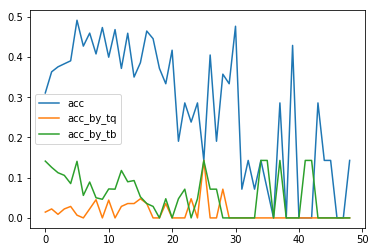

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", TIME_STEPS)
merged_metrics = np.zeros((TIME_STEPS,4))
for i in range(TIME_STEPS) :
    merged_metrics[i,:] = [metrics["acc"+str(i)],metrics["sc"+str(i)],metrics["acc_by_tq"+str(i)],metrics["acc_by_tb"+str(i)]]

plt.figure()
avg_metrics_df = pd.DataFrame(merged_metrics, columns=["acc","sc","acc_by_tq","acc_by_tb"])
avg_metrics_df["acc"].plot()
avg_metrics_df["acc_by_tq"].plot()
avg_metrics_df["acc_by_tb"].plot()
plt.legend()
display(avg_metrics_df)

Model artifacts were created as part of the training. You can run the following to get a Tensorboard visualization of our data model.

You will need to modify SAVE_FILENAME to the name of a checkpoint file that was produced in your training run. Refer to the output of your local training job.

In [44]:
from __future__ import print_function
from io import BytesIO
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

SAVE_FILENAME = "model.ckpt-4200"

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

tf.reset_default_graph()

with tf.Session() as sess:
    
    metadata_file = SAVE_PATH+SAVE_FILENAME+".meta"
    saver = tf.train.import_meta_graph(metadata_file)    
    restore_path = SAVE_PATH
    saver.restore(sess, tf.train.latest_checkpoint(restore_path))  

    show_graph(tf.get_default_graph())

INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


Great! Now we're ready to try remote training. We simply need to create a Sagemaker Tensorflow object and run the fit method:

In [20]:
hyperparameters = {
    "MAX_TIMESTEP" : TIME_STEPS,
    "INPUT_SIZE" : INPUT_SIZE,
    "OUTPUT_SIZE" : OUTPUT_SIZE,
    "BATCH_SIZE" : BATCH_SIZE,
    "LSTM_UNITS" : LSTM_UNITS,
    "MAX_EPOCHS" : EPOCHS,
    "POSITIVE_THRESHOLD" : POSITIVE_THRESHOLD,
    "MSE_POS_WEIGHT" : MSE_POS_WEIGHT,
    "LEARNING_RATE" : LEARNING_RATE,
    "DROPOUT_RNN_STATE_KEEP_PROB" : DROPOUT_RNN_STATE_KEEP_PROB,
    "DROPOUT_RNN_INPUT_KEEP_PROB" : DROPOUT_RNN_INPUT_KEEP_PROB,
    "TOP_PROD_BY_QTYBOUGHT" : TOP_PROD_BY_QTYBOUGHT,
    "TOP_PROD_BY_TIMESBOUGHT" : TOP_PROD_BY_TIMESBOUGHT,
    "K_PREDICTIONS" : K_PREDICTIONS,
    "L2_REG_DENSE" : L2_REG_DENSE
}

tf_estimator = TensorFlow(entry_point = "./"+CUSTOM_TF_MODEL_FILENAME, 
                            role = iamRole,
                            training_steps = training_steps, 
                            evaluation_steps = evaluation_steps,
                            train_instance_count = TRAINING_INSTANCE_COUNT, 
                            train_instance_type = TRAINING_INSTANCE_TYPE,
                            output_path = model_dir,
                            hyperparameters = hyperparameters,
                            code_location = code_dir)

tf_estimator.fit(training_dir)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-py2-gpu-2018-03-10-23-38-35-284


............................................................................................
executing startup script (first run)
2018-03-10 23:46:09,976 INFO - root - running container entrypoint
2018-03-10 23:46:09,976 INFO - root - starting train task
2018-03-10 23:46:12,191 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-03-10 23:46:13,179 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
2018-03-10 23:46:13,498 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.us-west-2.amazonaws.com
2018-03-10 23:46:13,604 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
INFO:tensorflow:----------------------TF_CONFIG--------------------------
INFO:tensorflow:{"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": 

INFO:tensorflow:global_step/sec: 3.83009
INFO:tensorflow:loss = 0.00069443684, step = 701 (26.109 sec)
INFO:tensorflow:accuracy = [0.34375    0.5        0.4375     0.34375    0.4347826  0.25
 0.15789473 0.29411766 0.46666667 0.54545456 0.33333334 0.5
 0.5        0.33333334 0.4        0.2        0.2        0.2
 0.6        0.         0.6        0.2        0.2        0.25
 0.5        0.         1.         0.         0.         0.
 0.         0.         0.33333334 0.33333334 0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.        ] (26.109 sec)
INFO:tensorflow:global_step/sec: 3.83845
INFO:tensorflow:loss = 0.0003311376, step = 801 (26.052 sec)
INFO:tensorflow:accuracy = [0.25       0.5        0.4375     0.5        0.4        0.46666667
 0.3846154  0.5833333  0.45454547 0.5        0.6        0.25
 0.75       0.25       0.         0.5        0.         0.
 1.         0.5        0.         0.5        1.   

INFO:tensorflow:Saving checkpoints for 1007 into s3://awslabs-ml-samples/models/rnn_purchase_predictor/sagemaker-tensorflow-py2-gpu-2018-03-10-23-38-35-284/checkpoints/model.ckpt.
INFO:tensorflow:global_step/sec: 2.72853
INFO:tensorflow:loss = 0.0007453821, step = 1101 (36.650 sec)
INFO:tensorflow:accuracy = [0.21875    0.375      0.5625     0.34375    0.5        0.6111111
 0.5        0.5        0.44444445 0.6666667  0.33333334 0.6666667
 0.33333334 0.5        0.5        0.75       1.         0.33333334
 0.33333334 0.6666667  0.         1.         0.         0.5
 0.         0.         0.5        0.         0.5        0.5
 0.         0.         1.         0.         1.         1.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (36.650 sec)
INFO:tensorflow:global_step/sec: 3.83242
INFO:tensorflow:loss = 0.0006304259, step = 1201 (26.093 sec)
INFO:tensorflow:accuracy = [0.34375    0.53125    0.28125    0.43

Training is complete! We can now deploy an endpoint for our model by simply calling the "deploy" method on our Sagemaker Tensorflow object. A RealTimePredictor object can then be created to handle the serialization and deserialization of request and responses from our newly created endpoint using protobuf encoded streams.

In [22]:
endpoint = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge').endpoint
rnn_purchase_predictor = RealTimePredictor(endpoint=endpoint,
                              deserializer=tf_deserializer, 
                              serializer=tf_serializer,
                              content_type=CONTENT_TYPE_OCTET_STREAM)

Let's predict what is the most likely product that will be purchased next using our validation set as the input.

In [23]:
n_previous_purchases = range(10)
customer_ids= [i for i,v in enumerate(SL_val) if v in n_previous_purchases]

predictions = np.zeros((len(customer_ids),4))

i=0
for id in customer_ids:
    
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "generic_model"
    request.model_spec.signature_name = DEFAULT_SERVING_SIGNATURE_DEF_KEY
    request.inputs['ph_inputs'].CopyFrom(tf.contrib.util.make_tensor_proto(X_val[id], shape=[1,49,3648]))
    request.inputs["ph_sequence_lengths"].CopyFrom(tf.contrib.util.make_tensor_proto(SL_val[id], shape=[1,])) 

    result = rnn_purchase_predictor.predict(request)

    predictions[i,:] = [id,
                        result.outputs["prod_indices"].int_val[0],
                        result.outputs["prod_indices"].int_val[1],
                        result.outputs["prod_indices"].int_val[2]]
    i=i+1

Let's plot the results:

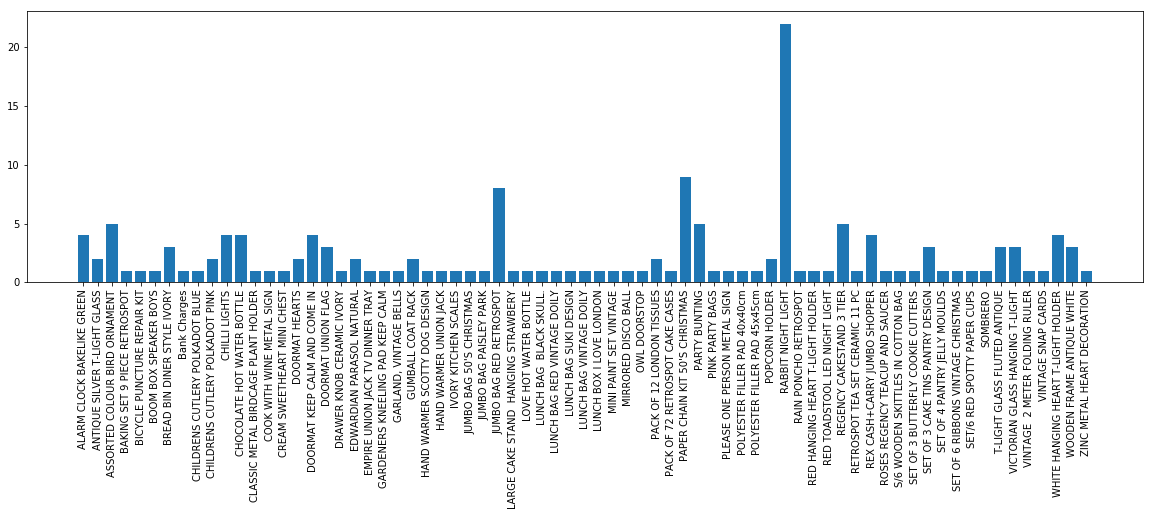

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

pred_df = pd.DataFrame(predictions,columns=["id","pred_1","pred_2","pred_3"])
#display(pred_df)
grouped = pred_df.groupby('pred_1')
pred_counts = grouped['pred_1'].agg(['count']).sort_values(by=['count'])
plot_data = pred_counts.join(products).sort_values(by="count")
#display(plot_data[["Description","count"]])

plt.figure(figsize=(20, 5))
plt.bar(plot_data["Description"],plot_data['count'])
plt.xticks(rotation='vertical')
plt.show()

If you download and deploy the model that I have provided <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/artifacts/models/model.tar.gz"> here </a>, you will see that the model predicts that a number of customers will buy the "Rabbit Night Light" next. Let's run a product promotion 


<img src=./bunny_lamp.jpg height="10%" width="10%" /img>

Let's create a sample CSV file that can be imported into Amazon Pinpoint to run a campaign. Feel free to modify YOUR_EMAIL_ADDRESS so that you can send an email to yourself for testing.

PROMO_PRODUCT_ID has been set to 29 as it represents the product index for the "Rabbit Night Light."

In [26]:
YOUR_EMAIL_ADDRESS= "your@email.com"
N_CHANNEL_TYPES = 4
N_ATTR = 2
SMS, APNS, EMAIL, GCM = range(N_CHANNEL_TYPES)
PROMO_PRODUCT_ID = 29 #RABBIT_NIGHT_LIGHT
PLATFORMS = ['Android', 'IOS']
CHANNEL_TYPES = ['SMS', 'APNS','EMAIL','GCM']
cohort = []
for i in range(predictions.shape[0]) :

    if predictions[i,1] == PROMO_PRODUCT_ID :
        address = "customer"+str(int(predictions[i,0]))+"@amazon.com"
        cohort.append([CHANNEL_TYPES[EMAIL]] + 
                      predictions[i,0:2].astype(np.int32).tolist() + 
                      [address, PLATFORMS[np.random.randint(2)]])

cohort[0][3]= YOUR_EMAIL_ADDRESS      
cohort_df = pd.DataFrame(cohort, columns=["ChannelType","User.UserAttributes.Id","Attributes.Prediction_ProductID", "Address","Demographic.Platform"])
display(cohort_df)

,ChannelType,User.UserAttributes.Id,Attributes.Prediction_ProductID,Address,Demographic.Platform
0,EMAIL,1,29,your@email.com,Android
1,EMAIL,25,29,customer25@amazon.com,IOS
2,EMAIL,33,29,customer33@amazon.com,IOS
3,EMAIL,51,29,customer51@amazon.com,Android
4,EMAIL,53,29,customer53@amazon.com,IOS
5,EMAIL,66,29,customer66@amazon.com,Android
6,EMAIL,67,29,customer67@amazon.com,Android
7,EMAIL,76,29,customer76@amazon.com,IOS
8,EMAIL,78,29,customer78@amazon.com,IOS
9,EMAIL,84,29,customer84@amazon.com,Android


Now let's write this file out to S3, so that it can be imported into Amazon Pinpoint. Modify S3_BUCKET and the PINPOINT_ENDPOINT_DIR to where you want to write out this file.

In [47]:
S3_BUCKET = "awslabs-ml-samples"
PINPOINT_ENDPOINT_DIR = "pinpoint/endpoints/"
PINPOINT_ENDPOINT_DATA = "product_"+str(PROMO_PRODUCT_ID)+"_cohort.csv"
print("Amazon Pinpoint endpoint file name: "+PINPOINT_ENDPOINT_DATA)

Amazon Pinpoint endpoint file name: product_29_cohort.csv


Write out the file to S3. Note that you may need to replicate or move this file to us-east-1. At the time of writing, Amazon Pinpoint is only available in that region. Follow the steps outlined in my <a href="https://aws.amazon.com/blogs/machine-learning/amazon-pinpoint-campaigns-driven-by-machine-learning-on-amazon-sagemaker/"> blog </a> to get an idea of how you can run your "predictive" campaign from Amazon Pinpoint.

In [ ]:
s3_resource = boto3.resource('s3')

csv_buffer = cohort_df.to_csv(None, index=False).encode()
s3_object = s3_resource.Object(S3_BUCKET, PINPOINT_ENDPOINT_DIR+PINPOINT_ENDPOINT_DATA)
s3_object.put(Body=csv_buffer)